In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import *
from statsmodels.graphics.tsaplots import *
from catboost import *
from sklearn.model_selection import *
from sklearn.metrics import *
from sklearn.datasets import load_diabetes
from sklearn.model_selection import *
from sklearn.linear_model import *
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import *
from sklearn.ensemble import *
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.svm import *
from sklearn.neighbors import *
from sklearn.neural_network import *
from sklearn.metrics import *
import pickle
import shap
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import *

plt.rcParams['font.sans-serif'] = ['SimHei']  # 黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决无法显示符号的问题
palette = 'deep'
sns.set(font='SimHei', font_scale=1.2, style='whitegrid', palette=palette)  # 解决Seaborn中文显示问题



D:\Users\win\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_excel('../../../preprocess/左侧填充-物流网络历史货量数据.xlsx')
df

,场地1,场地2,2021-01-01,2021-01-02,2021-01-03,2021-01-04,2021-01-05,2021-01-06,2021-01-07,2021-01-08,...,2022-12-22,2022-12-23,2022-12-24,2022-12-25,2022-12-26,2022-12-27,2022-12-28,2022-12-29,2022-12-30,2022-12-31
0,DC1,DC8,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
1,DC10,DC12,306,328,163,193,565,964,623,284,...,73,73,73,73,73,73,73,73,73,73
2,DC10,DC13,4,4,4,4,4,4,4,4,...,2,2,2,2,2,2,2,2,2,2
3,DC10,DC14,2613,2941,5968,4459,7646,5106,7155,5939,...,8663,9818,12248,13255,9896,15492,8230,29021,9991,13254
4,DC10,DC17,5,5,5,5,5,5,5,5,...,2,2,2,2,2,2,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1044,DC9,DC58,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
1045,DC9,DC62,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
1046,DC9,DC67,2,2,2,2,2,2,2,2,...,1,1,1,1,1,1,1,1,1,1
1047,DC9,DC79,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2


In [3]:
df = pd.melt(df, id_vars=['场地1', '场地2'], value_name='货量', var_name='日期')
df = df.sort_values(by=['场地1', '场地2', '日期'])
df = df.reset_index(drop=True)
df

,场地1,场地2,日期,货量
0,DC1,DC8,2021-01-01,3
1,DC1,DC8,2021-01-02,3
2,DC1,DC8,2021-01-03,3
3,DC1,DC8,2021-01-04,3
4,DC1,DC8,2021-01-05,3
...,...,...,...,...
765765,DC9,DC8,2022-12-27,5
765766,DC9,DC8,2022-12-28,5
765767,DC9,DC8,2022-12-29,5
765768,DC9,DC8,2022-12-30,5


In [4]:
ddf = df[(df['场地1'] == 'DC14') & (df['场地2'] == 'DC10')]
ddf

,场地1,场地2,日期,货量
48910,DC14,DC10,2021-01-01,273
48911,DC14,DC10,2021-01-02,247
48912,DC14,DC10,2021-01-03,160
48913,DC14,DC10,2021-01-04,288
48914,DC14,DC10,2021-01-05,188
...,...,...,...,...
49635,DC14,DC10,2022-12-27,28259
49636,DC14,DC10,2022-12-28,37386
49637,DC14,DC10,2022-12-29,23519
49638,DC14,DC10,2022-12-30,20311


In [5]:
ddf['日期'] = pd.to_datetime(ddf['日期'])
ddf['日期'] = ddf['日期'] - ddf['日期'].min()
ddf['日期'] = ddf['日期'].apply(lambda x: x.days)



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [6]:
ddf

,场地1,场地2,日期,货量
48910,DC14,DC10,0,273
48911,DC14,DC10,1,247
48912,DC14,DC10,2,160
48913,DC14,DC10,3,288
48914,DC14,DC10,4,188
...,...,...,...,...
49635,DC14,DC10,725,28259
49636,DC14,DC10,726,37386
49637,DC14,DC10,727,23519
49638,DC14,DC10,728,20311


In [7]:
ddf.set_index('日期', inplace=True)
ddf.sort_index(inplace=True)
ddf

,场地1,场地2,货量
日期,,,
0,DC14,DC10,273
1,DC14,DC10,247
2,DC14,DC10,160
3,DC14,DC10,288
4,DC14,DC10,188
...,...,...,...
725,DC14,DC10,28259
726,DC14,DC10,37386
727,DC14,DC10,23519


In [8]:
ddf.drop('场地1', axis=1, inplace=True)
ddf.drop('场地2', axis=1, inplace=True)
ddf.dtypes


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


货量    int64
dtype: object

In [9]:
ddf

,货量
日期,
0,273
1,247
2,160
3,288
4,188
...,...
725,28259
726,37386
727,23519


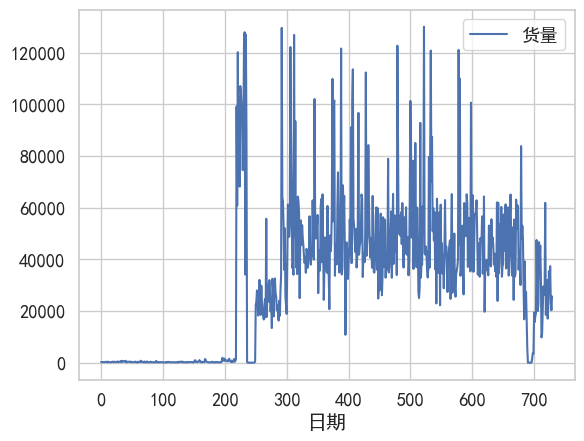

In [10]:
ddf.plot()
plt.show()

In [20]:
import statsmodels.api as sm

#data指你自己的时序数据，model='additive'代表是加法模式，
#extrapolate_trend='freq'表示trend 、resid频率会从最近点开始，并且会对最近点的缺失值进行填充
#更多参数设置请参考官方文档：https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.seasonal_decompose.html
decomposition = sm.tsa.seasonal_decompose(ddf, model='additive', extrapolate_trend='freq')
plt.rc('figure', figsize=(12, 8))
fig = decomposition.plot()
plt.show()

ValueError: You must specify a period or x must be a pandas object with a PeriodIndex or a DatetimeIndex with a freq not set to None

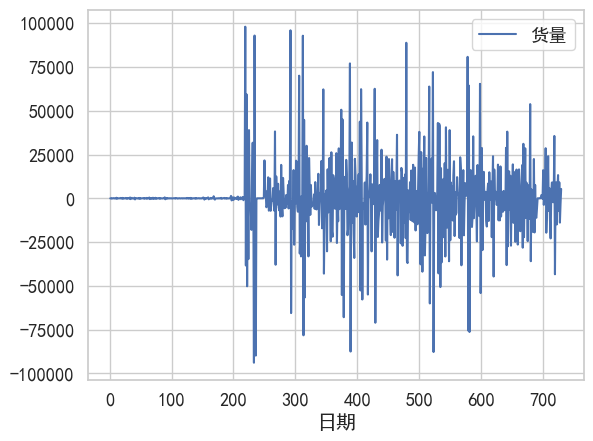

In [11]:
data_diff = ddf.diff().dropna()
data_diff.plot()
plt.show()

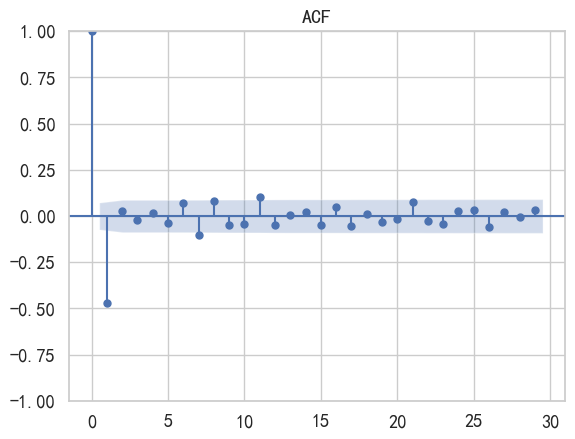

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.


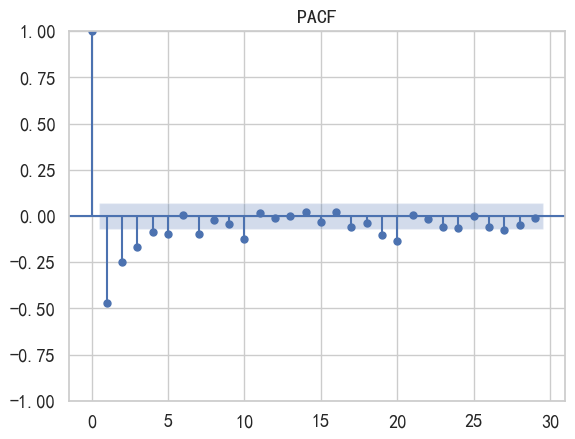

In [12]:
plot_acf(data_diff, title='ACF')
plt.show()

plot_pacf(data_diff, title='PACF')
plt.show()


An unsupported index was provided and will be ignored when e.g. forecasting.
An unsupported index was provided and will be ignored when e.g. forecasting.
An unsupported index was provided and will be ignored when e.g. forecasting.
Non-invertible starting MA parameters found. Using zeros as starting parameters.
Maximum Likelihood optimization failed to converge. Check mle_retvals
No supported index is available. Prediction results will be given with an integer index beginning at `start`.


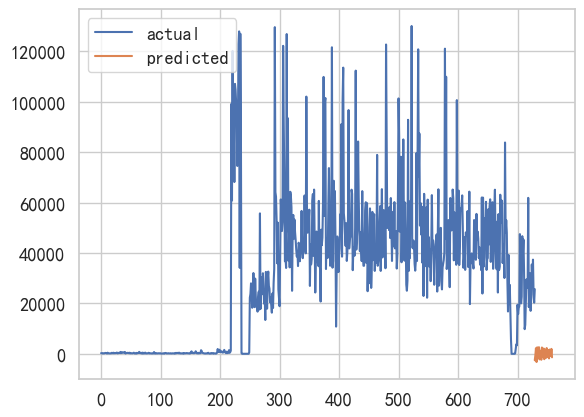

In [33]:
data = ddf

# 对时间序列进行差分处理
data_diff = data.diff().dropna()

# 拟合 ARIMA 模型并进行预测
model = ARIMA(data_diff, order=(5, 1, 5))
model_fit = model.fit()
forecast = model_fit.forecast(steps=30)

# 将预测结果还原回原始时间序列的尺度
data_pred_diff_cumsum = forecast.cumsum()
data_pred = pd.Series(data.iloc[0], index=data.index[:len(forecast)])
data_pred = data_pred.add(data_pred_diff_cumsum, fill_value=0)

# 绘制原始时间序列和预测时间序列的图表
plt.plot(data.index, data, label='actual')
plt.plot(data_pred.index, data_pred, label='predicted')
plt.legend()
plt.show()
